## Portfolio Allocation (Part 2): Using SciPy and Constructing Efficient Frontier

Running an MCS can be computationally expensive, especially when the portfolio comprises several hundreds, or even thousands of assets. One of the better methods to maximise SR is using an optimization algorithm. 

Modeling optimization functions in a general programming language can be tricky, and prone to error unless done in a well-defined framework. It necessitates construction of new classes, functions and algorithms which can be time-consuming. Fortunately having Scipy speeds up everything. The great thing about using Scipy is that facilitates faster construction of an optimization function. In this case of optimizing PF allocation we are looking to maximize SR by minimizing (neg) -SR using the Sequential Least Squares Programming (SLSQP) method. For more information regarding Scipy's optimize refer: https://docs.scipy.org/doc/scipy/reference/optimize.html 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Oil companies
bpcl = pd.read_csv('02BPCL_data.csv', index_col='Date', parse_dates=True)
bpcl = bpcl.loc['2009-1-1':'2013-12-31']
gail = pd.read_csv('02GAIL_data.csv', index_col='Date', parse_dates=True)
gail = gail.loc['2009-1-1':'2013-12-31']
hp = pd.read_csv('02HINDPETRO_data.csv', index_col='Date', parse_dates=True)
hp = hp.loc['2009-1-1':'2013-12-31']
ioc = pd.read_csv('02IOC_data.csv', index_col='Date', parse_dates=True)
ioc = ioc.loc['2009-1-1':'2013-12-31']
ongc = pd.read_csv('02ONGC_data.csv', index_col='Date', parse_dates=True)
ongc = ongc.loc['2009-1-1':'2013-12-31']
petronet = pd.read_csv('02PETRONET_data.csv', index_col='Date', parse_dates=True)
petronet = petronet.loc['2009-1-1':'2013-12-31']
reliance = pd.read_csv('02RELIANCE_data.csv', index_col='Date', parse_dates=True)
reliance = reliance.loc['2009-1-1':'2013-12-31']

In [3]:
bpcl = bpcl['adj_close']
gail = gail['adj_close']
hp = hp['adj_close']
ioc = ioc['adj_close']
ongc = ongc['adj_close']
petronet = petronet['adj_close']
reliance = reliance['adj_close']

In [4]:
oil_stocks_pf = pd.concat([bpcl, gail, hp, ioc, ongc, petronet, reliance], axis=1)

In [5]:
oil_stocks_pf.columns = ['bpcl','gail','hp','ioc', 'ongc', 'petronet', 'reliance']

In [6]:
oil_stocks_pf.head()

,bpcl,gail,hp,ioc,ongc,petronet,reliance
Date,,,,,,,
2009-01-02,27.151831,118.494614,15.977583,63.996998,65.375847,15.842308,269.053467
2009-01-05,26.815836,122.146706,15.887396,62.622910,69.695694,16.340376,285.670166
2009-01-06,27.883574,120.348808,16.094791,64.569122,69.085663,16.014713,286.726837
2009-01-07,27.465424,113.358810,15.926483,62.548656,66.365875,14.233174,251.139954
2009-01-09,28.421160,115.584320,16.091791,64.591095,64.299942,13.850048,241.204407


In [7]:
oil_mean_drets = oil_stocks_pf.pct_change(1).mean()
oil_mean_drets

bpcl        0.001198
gail        0.000700
hp          0.000798
ioc         0.000425
ongc        0.001068
petronet    0.001304
reliance    0.000566
dtype: float64

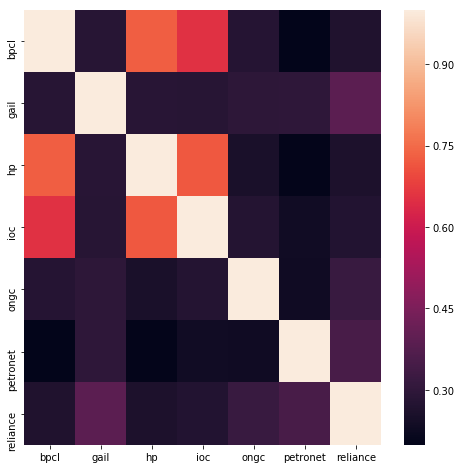

In [8]:
plt.figure(figsize=(8,8))
sns.heatmap(oil_stocks_pf.pct_change(1).corr())

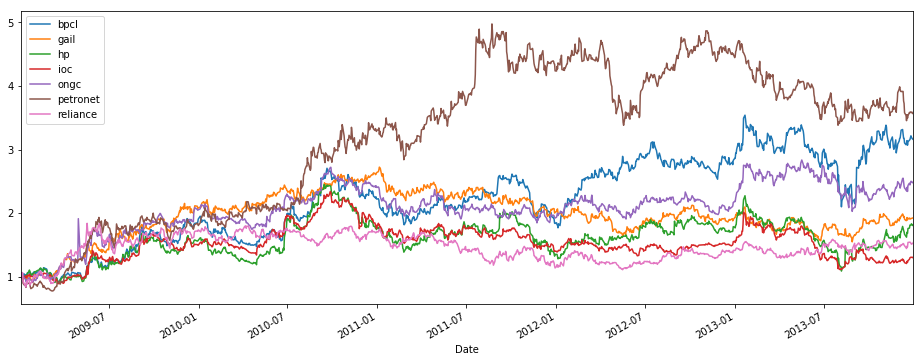

In [9]:
oil_stock_normed = oil_stocks_pf/oil_stocks_pf.iloc[0]
oil_stock_normed.plot(figsize=(16, 6))

In [10]:
oil_stock_drets = oil_stocks_pf.pct_change(1)
oil_stock_drets.head()

,bpcl,gail,hp,ioc,ongc,petronet,reliance
Date,,,,,,,
2009-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-05,-0.012375,0.030821,-0.005645,-0.021471,0.066077,0.031439,0.061760
2009-01-06,0.039817,-0.014719,0.013054,0.031078,-0.008753,-0.019930,0.003699
2009-01-07,-0.014996,-0.058081,-0.010457,-0.031292,-0.039368,-0.111244,-0.124114
2009-01-09,0.034798,0.019632,0.010379,0.032654,-0.031129,-0.026918,-0.039562


In [11]:
oil_log_ret = np.log(oil_stocks_pf/oil_stocks_pf.shift(1))
oil_log_ret.head()

,bpcl,gail,hp,ioc,ongc,petronet,reliance
Date,,,,,,,
2009-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-05,-0.012452,0.030355,-0.005661,-0.021705,0.063986,0.030955,0.059928
2009-01-06,0.039045,-0.014829,0.012970,0.030605,-0.008791,-0.020131,0.003692
2009-01-07,-0.015110,-0.059836,-0.010512,-0.031792,-0.040164,-0.117932,-0.132520
2009-01-09,0.034206,0.019442,0.010326,0.032132,-0.031624,-0.027287,-0.040366


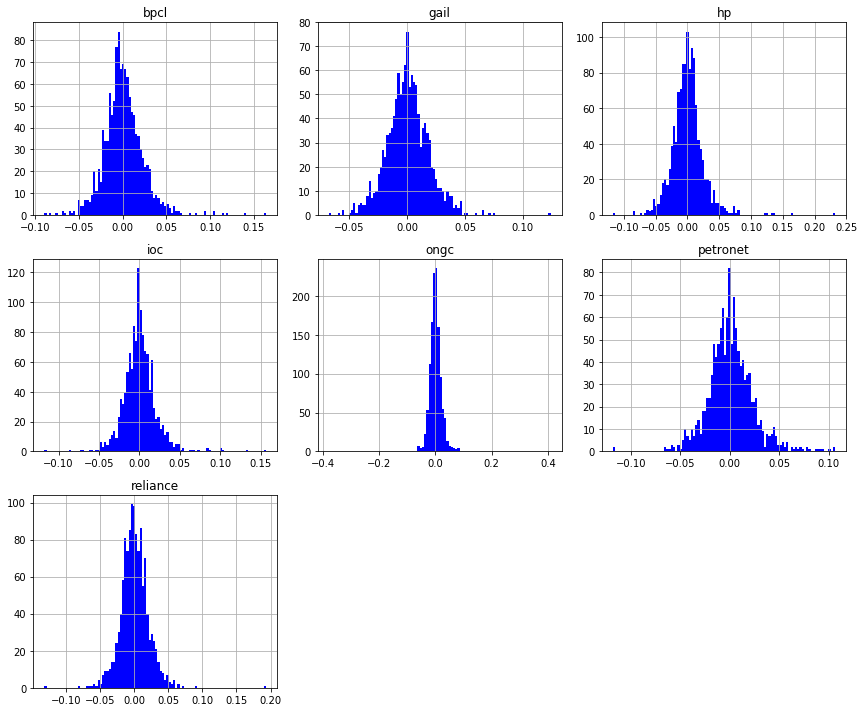

In [12]:
oil_log_ret.hist(bins=100,figsize=(12,10), color='blue')
plt.tight_layout()

In [13]:
oil_log_ret.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
bpcl,1231.0,0.000934,0.022886,-0.089364,-0.012096,-0.000519,0.012711,0.164100
gail,1231.0,0.000533,0.018218,-0.067718,-0.010425,0.000108,0.010883,0.123898
hp,1231.0,0.000483,0.024927,-0.117086,-0.012995,-0.000125,0.011957,0.232267
ioc,1231.0,0.000221,0.020138,-0.117679,-0.010954,-0.000321,0.009821,0.156922
ongc,1231.0,0.000735,0.025607,-0.379313,-0.011143,-0.000223,0.010841,0.409216
petronet,1231.0,0.001039,0.022988,-0.117932,-0.011990,0.000000,0.012880,0.106510
reliance,1231.0,0.000351,0.020682,-0.132520,-0.011939,-0.000490,0.011860,0.193668


In [14]:
oil_log_ret.mean() * 252

bpcl        0.235370
gail        0.134421
hp          0.121838
ioc         0.055815
ongc        0.185259
petronet    0.261771
reliance    0.088460
dtype: float64

In [15]:
oil_log_ret.cov()

,bpcl,gail,hp,ioc,ongc,petronet,reliance
bpcl,0.000524,0.000117,0.000420,0.000300,0.000166,0.000106,0.000125
gail,0.000117,0.000332,0.000130,0.000103,0.000140,0.000125,0.000144
hp,0.000420,0.000130,0.000621,0.000362,0.000165,0.000118,0.000132
ioc,0.000300,0.000103,0.000362,0.000406,0.000142,0.000109,0.000112
ongc,0.000166,0.000140,0.000165,0.000142,0.000656,0.000139,0.000169
petronet,0.000106,0.000125,0.000118,0.000109,0.000139,0.000528,0.000167
reliance,0.000125,0.000144,0.000132,0.000112,0.000169,0.000167,0.000428


In [16]:
oil_log_ret.cov()*252

,bpcl,gail,hp,ioc,ongc,petronet,reliance
bpcl,0.131990,0.029602,0.105926,0.075668,0.041741,0.026592,0.031494
gail,0.029602,0.083641,0.032658,0.025848,0.035237,0.031515,0.036329
hp,0.105926,0.032658,0.156578,0.091182,0.041571,0.029654,0.033333
ioc,0.075668,0.025848,0.091182,0.102200,0.035880,0.027480,0.028140
ongc,0.041741,0.035237,0.041571,0.035880,0.165236,0.035087,0.042707
petronet,0.026592,0.031515,0.029654,0.027480,0.035087,0.133168,0.042162
reliance,0.031494,0.036329,0.033333,0.028140,0.042707,0.042162,0.107795


#### Single Run for Some Random Allocation

In [17]:
# Set seed (optional)
np.random.seed(42)

# Stock Columns
print('Oil Stocks')
print(oil_stocks_pf.columns)
print('\n')

# Create Random Weights
print('Creating Random Weights')
weights = np.array(np.random.random(7))
print(weights)
print('\n')

# Rebalance Weights
print('Rebalance to sum to 1.0')
weights = weights / np.sum(weights)
print(weights)
print('\n')

# Expected Return
print('Expected Oil Portfolio Return')
exp_ret = np.sum(oil_log_ret.mean() * weights) *252
print(exp_ret)
print('\n')

# Expected Variance
print('Expected Oil Volatility')
exp_vol = np.sqrt(np.dot(weights.T, np.dot(oil_log_ret.cov() * 252, weights)))
print(exp_vol)
print('\n')

# Sharpe Ratio
SR = exp_ret/exp_vol
print('Oil Sharpe Ratio')
print(SR)

Oil Stocks
Index(['bpcl', 'gail', 'hp', 'ioc', 'ongc', 'petronet', 'reliance'], dtype='object')


Creating Random Weights
[ 0.37454012  0.95071431  0.73199394  0.59865848  0.15601864  0.15599452
  0.05808361]


Rebalance to sum to 1.0
[ 0.12377385  0.31418148  0.24190121  0.19783799  0.0515593   0.05155133
  0.01919483]


Expected Oil Portfolio Return
0.1366245219224595


Expected Oil Volatility
0.247181748974


Oil Sharpe Ratio
0.552729004022


#### Use Scipy's Optimize Function for Maximize Sharpe Ratio

In [18]:
def get_ret_vol_sr(weights):
    """
    Takes in weights, returns array or return, volatility, sharpe ratio
    """
    weights = np.array(weights)
    oil_ret = np.sum(oil_log_ret.mean() * weights) * 252
    oil_vol = np.sqrt(np.dot(weights.T, np.dot(oil_log_ret.cov() * 252, weights)))
    oil_sr = oil_ret/oil_vol
    return np.array([oil_ret, oil_vol, oil_sr])

In [19]:
from scipy.optimize import minimize

In [20]:
def neg_sharpe(weights):
    return  get_ret_vol_sr(weights)[2] * -1

In [21]:
# Contraints
def check_sum(weights):
    '''
    Returns 0 if sum of weights is 1.0
    '''
    return np.sum(weights) - 1

In [22]:
# By convention of minimize function it should be a function that returns zero for conditions
cons = ({'type':'eq','fun': check_sum})

In [23]:
bounds = tuple((0, 1) for x in range(len(oil_stocks_pf.columns)))

In [24]:
init_guess = len(oil_stocks_pf.columns)*[1/len(oil_stocks_pf.columns),]

In [25]:
# Sequential Least SQuares Programming (SLSQP).
opt_results = minimize(neg_sharpe,init_guess,method='SLSQP',bounds=bounds,constraints=cons)

In [52]:
%time
opt_results

Wall time: 0 ns


     fun: -0.9064474159900282
     jac: array([ -3.26842070e-04,  -2.20537186e-06,   3.42459053e-01,
         4.19715539e-01,   1.27062201e-04,   2.40042806e-04,
         1.86519861e-01])
 message: 'Optimization terminated successfully.'
    nfev: 54
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([  3.50759225e-01,   1.19167904e-01,   0.00000000e+00,
         9.24824453e-17,   1.09107103e-01,   4.20965769e-01,
         0.00000000e+00])

In [53]:
opt_results.x

array([  3.50759225e-01,   1.19167904e-01,   0.00000000e+00,
         9.24824453e-17,   1.09107103e-01,   4.20965769e-01,
         0.00000000e+00])

In [54]:
get_ret_vol_sr(opt_results.x)

array([ 0.22898646,  0.25261968,  0.90644742])

### MCS for comparison

In [56]:
%%time
oil_num_ports = 25000

oil_all_weights = np.zeros((oil_num_ports,len(oil_log_ret.columns)))
oil_ret_arr = np.zeros(oil_num_ports)
oil_vol_arr = np.zeros(oil_num_ports)
oil_sharpe_arr = np.zeros(oil_num_ports)

for ind in range(oil_num_ports):

    # Create Random Weights
    weights = np.array(np.random.random(7))

    # Rebalance Weights
    weights = weights / np.sum(weights)
    
    # Save Weights
    oil_all_weights[ind,:] = weights

    # Expected Return
    oil_ret_arr[ind] = np.sum((oil_log_ret.mean() * weights) *252)

    # Expected Variance
    oil_vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(oil_log_ret.cov() * 252, weights)))

    # Sharpe Ratio
    oil_sharpe_arr[ind] = oil_ret_arr[ind]/oil_vol_arr[ind]

Wall time: 28.7 s


In [57]:
oil_sharpe_arr.max()

0.87370633292117394

In [58]:
oil_sharpe_arr.argmax()

4968

In [59]:
oil_all_weights[(oil_sharpe_arr.argmax()), :]

array([ 0.36063932,  0.02642677,  0.0391243 ,  0.00724965,  0.12762802,
        0.38898714,  0.04994481])

In [60]:
max_oil_sr_ret = oil_ret_arr[oil_sharpe_arr.argmax()]
max_oil_sr_vol = oil_vol_arr[oil_sharpe_arr.argmax()]

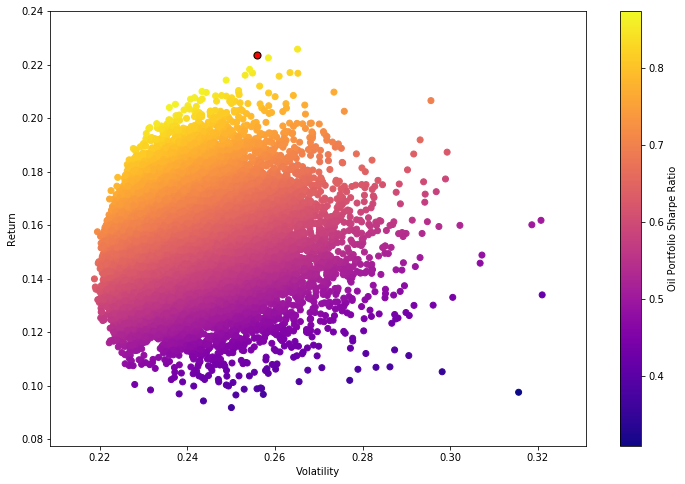

In [61]:
plt.figure(figsize=(12,8))
plt.scatter(oil_vol_arr,oil_ret_arr,c=oil_sharpe_arr,cmap='plasma')
plt.colorbar(label='Oil Portfolio Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

# Add red dot for max SR
plt.scatter(max_oil_sr_vol,max_oil_sr_ret,c='red',s=50,edgecolors='black')

Here's a comparison of percentage allocation and findings from MCS method and Scipy optimizer.

|Stock | MCS Allocation % | SciPy Opt. Allocation % | 
|------|----------------|-----------------------|
| bpcl | 36.0  | 35.1 |
| gail | 2.64  | 11.9 |
| hp | 3.9  | 0.0 | 
| ioc |  0.7 | ~0.0 |
| ongc |  12.8 | 10.9 |
| petronet |  38.9 | 42.1 |
| reliance |  4.9 | 0.0 |
| Best SR |  0.873 | 0.906 |
| Volatility |  0.255 | 0.242 |
| Returns | 0.223  | 0.209  |



### All Optimal Portfolios (Efficient Frontier)

In [35]:
# Our returns go from 0 to somewhere along 0.4
# Create a linspace number of points to calculate x on
frontier_y = np.linspace(0,0.5,25)

In [36]:
def minimize_volatility(weights):
    return  get_ret_vol_sr(weights)[1]

In [37]:
frontier_volatility = []

for possible_return in frontier_y:
    # function for return
    cons = ({'type':'eq','fun': check_sum},
            {'type':'eq','fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = minimize(minimize_volatility,init_guess,method='SLSQP',bounds=bounds,constraints=cons)
    
    frontier_volatility.append(result['fun'])

Text(0,0.5,'Annualized Return (Oil)')

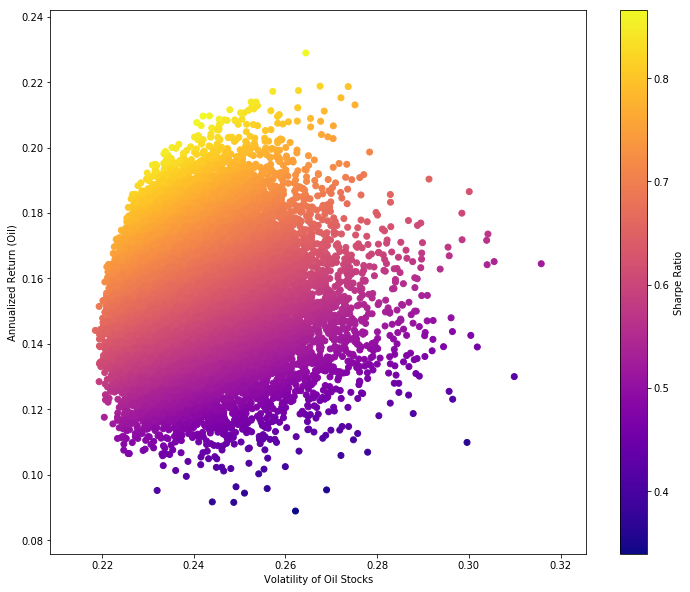

In [38]:
plt.figure(figsize=(12,10))
plt.scatter(oil_vol_arr,oil_ret_arr,c=oil_sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility of Oil Stocks')
plt.ylabel('Annualized Return (Oil)')

In [64]:
max_oil_sr_ret

0.22349526977689313

In [65]:
max_oil_sr_vol

0.25580136180271562